# 1. Importing necessary libraries.

In [1]:
import os
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder

import torch
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

import warnings 
warnings.filterwarnings('ignore')

2024-06-23 22:26:00.102881: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 22:26:00.103040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 22:26:00.238197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. Loading data, and converting it into a DataFrame.

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/india-news-headlines-updated-data/india-news-headlines.csv


In [3]:
data = pd.read_csv('/kaggle/input/india-news-headlines-updated-data/india-news-headlines.csv')

In [4]:
df = pd.DataFrame(data)

# 3. Exploratory Data Analysis (EDA).

In [5]:
df.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [6]:
# Converting 'publish_date' column to string and then to datetime.
df['publish_date'] = pd.to_datetime(df['publish_date'].astype(str), format='%Y%m%d')

In [7]:
# Finding starting and ending dates.
start_date = df['publish_date'].min()
end_date = df['publish_date'].max()

In [8]:
print(f"Starting Date: {start_date}")
print(f"Ending Date: {end_date}")

Starting Date: 2001-01-02 00:00:00
Ending Date: 2022-03-31 00:00:00


In [9]:
df.shape

(3650970, 3)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype         
---  ------             -----         
 0   publish_date       datetime64[ns]
 1   headline_category  object        
 2   headline_text      object        
dtypes: datetime64[ns](1), object(2)
memory usage: 83.6+ MB


In [11]:
df['headline_category'].unique()

array(['unknown', 'entertainment.hindi.bollywood', 'india', ...,
       'sports.football.euro-2021', 'business.markets.ipo',
       'sports.tokyo-olympics.india-in-tokyo'], dtype=object)

In [12]:
# Observing total occurrences of each unique value in 'headline_category' column.
category_counts = df['headline_category'].value_counts()

In [13]:
print(category_counts)

headline_category
india                                            297491
unknown                                          209583
city.mumbai                                      150451
city.delhi                                       137648
business.india-business                          121195
                                                  ...  
2013-the-year-sachin-bids-adieu.football-2013         8
business.cryptocurrency.bitcoin                       8
sports.cricket.sri-lanka-in-new-zealand               8
toi-homepage-slug                                     8
sports.hockey.hockey-world-cup-2014                   8
Name: count, Length: 1041, dtype: int64


In [14]:
df.describe()

,publish_date
count,3650970
mean,2013-08-16 22:35:40.718986496
min,2001-01-02 00:00:00
25%,2010-04-23 00:00:00
50%,2014-02-27 00:00:00
75%,2017-09-27 00:00:00
max,2022-03-31 00:00:00


In [15]:
df['headline_text'].describe()

count              3650970
unique             3387380
top       Straight Answers
freq                  6723
Name: headline_text, dtype: object

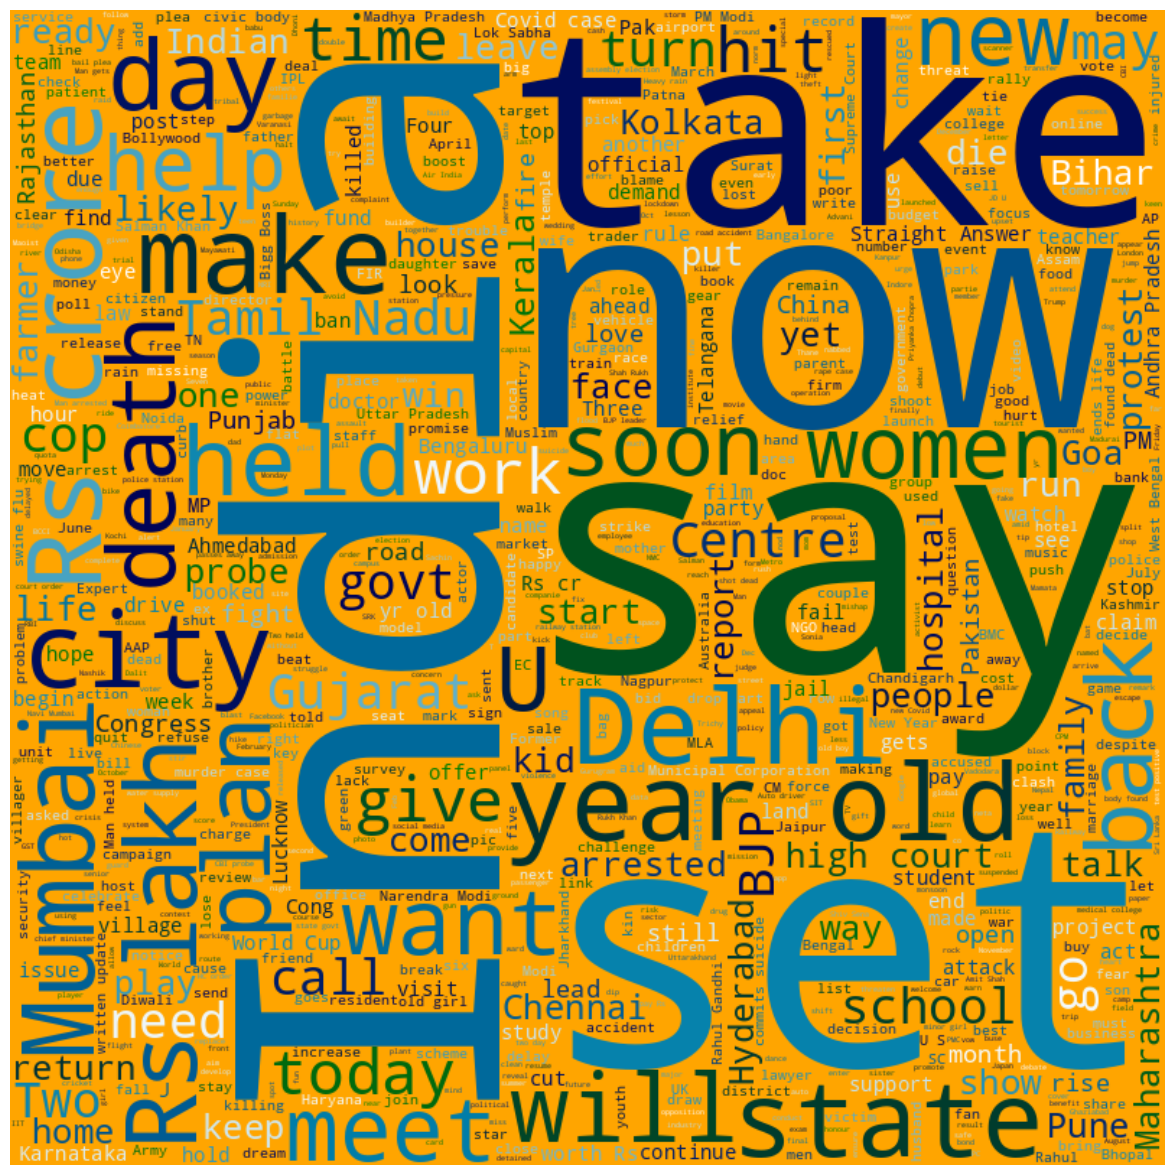

In [16]:
# Setting the figure size.
plt.figure(figsize=(15, 15))

# Combining all the text from 'headline_text' column into a single string.
combined_text = " ".join(df['headline_text'].tolist())

# Creating a WordCloud object with specified parameters.
wordcloud = WordCloud(
    width=800,
    height=800,
    stopwords=STOPWORDS,
    background_color='orange',
    max_words=800,
    colormap="ocean"
).generate(combined_text)

# Displaying generated word cloud.
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 4. Data Cleaning and Preprocessing.

In [17]:
# Function for converting text to lowercase.
def convert_to_lowercase(text):
    return text.lower()

In [18]:
# Function for removing punctuations.
def remove_punctuations(text):
    return re.sub(r'[^\w\s]', '', text)

In [19]:
# Function for removing repeated characters.
def remove_repeating_characters(text):
    return re.sub(r'(\w)\1+', r'\1', text)

In [20]:
# Function for removing URL's.
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

In [21]:
# Function for removing numerical numbers.
def remove_numerical_numbers(text):
    return re.sub(r'\d+', '', text)

In [22]:
# Function for removing stop words.
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

In [23]:
# Function for tokenization and stemming.
def preprocess_text(text):
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in text.split()]
    return ' '.join(tokens)

In [24]:
# Creating a list of all cleaning functions.
cleaning_functions = [
    convert_to_lowercase,
    remove_punctuations,
    remove_repeating_characters,
    remove_urls,
    remove_numerical_numbers,
    remove_stop_words,
    preprocess_text
]

In [25]:
# Applying each cleaning function on the data from the list through a for loop.
for func in cleaning_functions:
    df['headline_text'] = df['headline_text'].apply(func)

# 5. Implementing pre-trained pretrained BERT model for sentiment extraction.

### 5.1. Loading the pre-trained BERT model and tokenizer.

In [26]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

### 5.2. Initializing sentiment analysis pipeline using BERT with GPU

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentiment_analyzer = pipeline("sentiment-analysis", model=model.to(device), tokenizer=tokenizer, device=device)

### 5.3. Defining a Function to get sentiment using BERT.

In [28]:
def bert_sentiment_extracter(text):
    result = sentiment_analyzer(text)
    return result[0]['label']

### 5.4. Applying sentiment extracter function on the 'headline_text' column.

In [29]:
df['BERT_Sentiment'] = df['headline_text'].apply(bert_sentiment_extracter)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [30]:
df['BERT_Sentiment'].unique()

array(['1 star', '4 stars', '3 stars', '5 stars', '2 stars'], dtype=object)

### 5.5. Mapping default BERT returned sentiment labels with only integers having int64 datatype.

In [31]:
label_mapping = {'1 star': 1, '2 stars': 2, '3 stars': 3, '4 stars': 4, '5 stars': 5}
df['polarity_score'] = df['BERT_Sentiment'].map(label_mapping).astype('int64')

### 5.6. Now, mapping numerical sentiment score with polarity labels (negative, neutral, and positive).

In [32]:
def assign_polarity_label(score):
    if score < 3:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Positive'

In [33]:
df['polarity_label'] = df['polarity_score'].apply(assign_polarity_label)

# 6. Finalizing data for transforming into a Dataset.

### 6.1. Encoding polarity labels into numerical digits (-1, 0, and 1).

In [34]:
def polarity_encoding(label):
    if label == 'Negative':
        return -1
    elif label == 'Neutral':
        return 0
    elif label == 'Positive':
        return 1
    else:
        return None

In [35]:
df['polarity_encoded'] = df['polarity_label'].apply(polarity_encoding)

### 6.2. Converting 'Datetime' column into DateTime data type.

In [36]:
df['publish_date'] = pd.to_datetime(df['publish_date'])

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 7 columns):
 #   Column             Dtype         
---  ------             -----         
 0   publish_date       datetime64[ns]
 1   headline_category  object        
 2   headline_text      object        
 3   BERT_Sentiment     object        
 4   polarity_score     int64         
 5   polarity_label     object        
 6   polarity_encoded   int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 195.0+ MB


In [38]:
df.head()

,publish_date,headline_category,headline_text,BERT_Sentiment,polarity_score,polarity_label,polarity_encoded
0,2001-01-02,unknown,statu quo wil disturb ayodhya say vajpay,1 star,1,Negative,-1
1,2001-01-02,unknown,fisur huriyat pak visit,4 stars,4,Positive,1
2,2001-01-02,unknown,america unwant head india,1 star,1,Negative,-1
3,2001-01-02,unknown,bigwig destin goa,3 stars,3,Neutral,0
4,2001-01-02,unknown,extra buse clear tourist trafic,5 stars,5,Positive,1


# 7. Producing Dataset in a CSV file.

In [39]:
# Defining the file path for Kaggle output.
file_path = "/kaggle/working/india-news-headlines-with-polarities.csv"

In [40]:
# Saving the DataFrame to a CSV file.
df.to_csv(file_path, index=False)
print(f"File saved at: {file_path}")

File saved at: /kaggle/working/india-news-headlines-with-polarities.csv
